In [1]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd
from functions import *

### Getting Dataset

In [2]:
x = get_x_data()

In [3]:
y = get_target()

In [4]:
y = pd.get_dummies(pd.DataFrame(y))

In [5]:
y = y.replace({True: 1, False: 0})

In [6]:
y = np.asarray(y)

### Data Augmentation Before Spltting

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16
from tensorflow.keras.applications import resnet, densenet, vgg16

2024-04-29 13:25:28.789624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 13:25:29.119009: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:25:29.164482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:25:29.

In [8]:
from tensorflow.keras.layers import RandomZoom, RandomContrast, RandomRotation

In [9]:
data_augmentation_layers = [
    RandomZoom((0.1, 0.5)),
    RandomRotation(0.5),
    RandomContrast(0.2)
]


def data_augmentation(imgs):
    for layer in data_augmentation_layers:
        imgs = layer(imgs)
    return imgs

In [10]:
augmented_x = data_augmentation(x)

2024-04-29 13:25:32.136964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:25:32.137272: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-29 13:25:32.137308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-29 13:25:32.138365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(augmented_x), y, test_size = 0.3)

In [13]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

In [14]:
reconstructed_model = load_model('my_model.keras')
reconstructed_aug_model = load_model('my_aug_model.keras')

In [19]:
reconstructed_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])
reconstructed_aug_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])

In [22]:
history = reconstructed_model.fit(x_test, y_test, epochs = 8)

Epoch 1/8
5/5 [==============================] - 8s 1s/step - loss: 0.9120 - auc: 0.8971
Epoch 2/8
5/5 [==============================] - 5s 1s/step - loss: 0.7245 - auc: 0.9357
Epoch 3/8
5/5 [==============================] - 5s 1s/step - loss: 0.5709 - auc: 0.9599
Epoch 4/8
5/5 [==============================] - 5s 1s/step - loss: 0.4233 - auc: 0.9769
Epoch 5/8
5/5 [==============================] - 5s 1s/step - loss: 0.3802 - auc: 0.9824
Epoch 6/8
5/5 [==============================] - 5s 1s/step - loss: 0.3154 - auc: 0.9901
Epoch 7/8
5/5 [==============================] - 6s 1s/step - loss: 0.2735 - auc: 0.9930
Epoch 8/8
5/5 [==============================] - 6s 1s/step - loss: 0.2208 - auc: 0.9971


In [23]:
aug_history = reconstructed_aug_model.fit(x_test, y_test, epochs = 8)

Epoch 1/8
5/5 [==============================] - 7s 1s/step - loss: 0.8845 - auc_1: 0.9025
Epoch 2/8
5/5 [==============================] - 5s 1s/step - loss: 0.6319 - auc_1: 0.9516
Epoch 3/8
5/5 [==============================] - 5s 1s/step - loss: 0.5443 - auc_1: 0.9654
Epoch 4/8
5/5 [==============================] - 5s 1s/step - loss: 0.4623 - auc_1: 0.9760
Epoch 5/8
5/5 [==============================] - 5s 1s/step - loss: 0.3680 - auc_1: 0.9865
Epoch 6/8
5/5 [==============================] - 5s 1s/step - loss: 0.3184 - auc_1: 0.9926
Epoch 7/8
5/5 [==============================] - 6s 1s/step - loss: 0.2791 - auc_1: 0.9947
Epoch 8/8
5/5 [==============================] - 6s 1s/step - loss: 0.2284 - auc_1: 0.9972


### ROC Curves

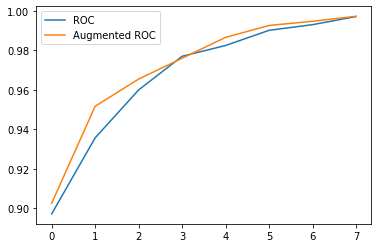

In [31]:
plt.plot(range(len(history.history['auc'])), history.history['auc'], label = 'ROC')
plt.plot(range(len(aug_history.history['auc_1'])), aug_history.history['auc_1'], label = 'Augmented ROC')
plt.legend()